In [18]:
import numpy as np
from scipy.stats import johnsonsu, skew, kurtosis as scipy_kurtosis
from scipy.optimize import root
import matplotlib.pyplot as plt

In [19]:
def _moment_equations(params, target_skew, target_kurt):
    """
    Equations for root finding. We want the skewness and kurtosis
    of a Johnson SU distribution (with loc=0, scale=1) to match targets.
    """
    a, b = params
    if b <= 0:  # b must be positive for Johnson SU
        return [1e6, 1e6] # Return large error if b is invalid

    # SciPy's johnsonsu.stats returns (mean, variance, skewness, excess_kurtosis)
    try:
        # Forcing loc=0 and scale=1 to isolate shape parameters a and b
        mean_jsu, var_jsu, skew_jsu, kurt_jsu = johnsonsu.stats(a, b, loc=0, scale=1, moments='mvsk')
        
        # Handle cases where moments might not be defined for certain a, b or var is non-positive
        if np.isnan(skew_jsu) or np.isnan(kurt_jsu) or var_jsu <= 0 or np.isinf(skew_jsu) or np.isinf(kurt_jsu):
            return [1e6, 1e6]
            
    except (ValueError, FloatingPointError) as e: # Catch errors during moment calculation
        # print(f"Warning: Error calculating moments for a={a}, b={b}: {e}")
        return [1e6, 1e6]

    err_skew = skew_jsu - target_skew
    err_kurt = kurt_jsu - target_kurt
    return [err_skew, err_kurt]

In [20]:
def _find_johnsonsu_params(target_skew, target_kurtosis):
    """
    Finds the Johnson SU parameters 'a' and 'b' that best match
    the target skewness and kurtosis.
    """
    # Check if the target skewness and kurtosis are achievable by Johnson SU
    # Condition: kurtosis > skewness^2 - 2
    if target_kurtosis <= target_skew**2 - 2:
        print(f"Warning: Target kurtosis ({target_kurtosis}) and skewness ({target_skew}) may not be achievable "
              f"by Johnson SU distribution (kurtosis > skewness^2 - 2 is not met). "
              f"The results might not be accurate.")
        # Proceeding anyway, but the optimization might fail or give poor results.

    # Initial guess for a and b.
    # 'a' influences skewness, 'b' influences kurtosis.
    # A common starting point.
    initial_guess = [target_skew if target_skew != 0 else 0.01 , np.sqrt(2*target_kurtosis + 4) if target_kurtosis > -1.9 else 2.0] 
    if initial_guess[1] <=0: initial_guess[1] = 2.0 # Ensure b_guess is positive
    
    # print(f"Initial guess for (a,b): {initial_guess}")

    solution = root(_moment_equations, initial_guess, args=(target_skew, target_kurtosis), method='lm', tol=1e-6)
    
    if solution.success:
        a_opt, b_opt = solution.x
        # print(f"Optimization successful. Found params: a={a_opt}, b={b_opt}")
        # Verify found parameters if needed
        # _, _, final_skew, final_kurt = johnsonsu.stats(a_opt, b_opt, loc=0, scale=1, moments='mvsk')
        # print(f"Achieved skew: {final_skew}, kurt: {final_kurt} with a={a_opt}, b={b_opt}")
        return a_opt, b_opt
    else:
        print(f"Warning: Optimization for Johnson SU parameters failed. Message: {solution.message}")
        print("Using a default or returning None. The generated distribution might not match target skew/kurtosis.")
        # Fallback or raise error
        # As a simple fallback, try to return something that might work for less extreme cases,
        # or signal that the specific skew/kurtosis combination is problematic.
        # This part might need more sophisticated error handling or alternative strategies.
        # For now, let's try with a more stable guess if primary fails, e.g. a=0 (symmetric attempt)
        # solution_fallback = root(_moment_equations, [0.0, 2.0], args=(target_skew, target_kurtosis), method='lm')
        # if solution_fallback.success:
        #     print("Fallback optimization successful.")
        #     return solution_fallback.x
        return None, None # Or raise an error: raise RuntimeError("Could not find Johnson SU parameters.")

In [ ]:
def simulate_stock_prices_with_moments(n_prices, target_mean, target_std_dev, target_skewness, target_kurtosis_excess):
    """
    Simulates n_prices stock prices with specified mean, std_dev, skewness, and excess kurtosis.
    Also plots a histogram with lines for mean, median, and approximate mode.

    Args:
        n_prices (int): Number of stock prices to simulate.
        target_mean (float): The desired mean of the stock prices.
        target_std_dev (float): The desired standard deviation of the stock prices.
        target_skewness (float): The desired skewness of the stock prices.
        target_kurtosis_excess (float): The desired excess kurtosis (Fisher kurtosis)
                                       of the stock prices. Normal distribution has excess kurtosis = 0.

    Returns:
        tuple: (list of simulated prices, dict of actual moments) or (None, None) if params not found.
    """
    a_jsu, b_jsu = _find_johnsonsu_params(target_skewness, target_kurtosis_excess)

    if a_jsu is None or b_jsu is None or b_jsu <=0 : 
        print("Could not determine valid Johnson SU parameters. Aborting simulation.")
        return None, None
    
    initial_variates = johnsonsu.rvs(a_jsu, b_jsu, loc=0, scale=1, size=n_prices, random_state=None) 

    mean_initial = np.mean(initial_variates)
    std_initial = np.std(initial_variates)
    
    if std_initial < 1e-9 : 
        print("Warning: Standard deviation of initial Johnson SU variates is zero or too small. Cannot reliably standardize.")
        simulated_prices = np.full(n_prices, target_mean)
    else:
        standardized_variates = (initial_variates - mean_initial) / std_initial
        simulated_prices = target_mean + standardized_variates * target_std_dev

    actual_mean = np.mean(simulated_prices)
    actual_std = np.std(simulated_prices)
    actual_skew = skew(simulated_prices)
    actual_kurtosis = scipy_kurtosis(simulated_prices, fisher=True) 
    actual_median = np.median(simulated_prices)

    actual_moments = {
        "mean": actual_mean,
        "std_dev": actual_std,
        "skewness": actual_skew,
        "kurtosis_excess": actual_kurtosis,
        "median": actual_median
    }

    print("\n--- Target Moments ---")
    print(f"Mean: {target_mean:.4f}")
    print(f"Std Dev: {target_std_dev:.4f}")
    print(f"Skewness: {target_skewness:.4f}")
    print(f"Excess Kurtosis: {target_kurtosis_excess:.4f}")

    print("\n--- Actual Moments of Simulated Data (N={}) ---".format(n_prices))
    print(f"Mean: {actual_mean:.4f}")
    print(f"Std Dev: {actual_std:.4f}")
    print(f"Skewness: {actual_skew:.4f}")
    print(f"Excess Kurtosis: {actual_kurtosis:.4f}")
    print(f"Median: {actual_median:.4f}")
    
    plt.figure(figsize=(12, 7)) # Increased figure size for better legend visibility
    
    # Plot histogram and get counts and bin edges for mode calculation
    num_bins = min(100, int(np.sqrt(n_prices)))
    counts, bin_edges, patches = plt.hist(simulated_prices, bins=num_bins, density=True, alpha=0.75, label=f'Simulated Prices\nSkew: {actual_skew:.2f}, Kurt: {actual_kurtosis:.2f}')
    
    # Calculate approximate mode from histogram
    mode_bin_index = np.argmax(counts)
    approx_mode = (bin_edges[mode_bin_index] + bin_edges[mode_bin_index+1]) / 2
    actual_moments["mode_approx"] = approx_mode
    print(f"Mode (approx. from hist): {approx_mode:.4f}")

    # Add vertical lines for mean, median, and mode
    plt.axvline(actual_mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {actual_mean:.2f}')
    plt.axvline(actual_median, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {actual_median:.2f}')
    plt.axvline(approx_mode, color='blue', linestyle='dashed', linewidth=1.5, label=f'Mode (approx.): {approx_mode:.2f}')
    
    plt.title(f'Histogram of Simulated Stock Prices (N={n_prices})')
    plt.xlabel('Price')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    return simulated_prices.tolist(), actual_moments

Simulating 100000 stock prices with specified moments...

--- Target Moments ---
Mean: 100.0000
Std Dev: 15.0000
Skewness: 0.8000
Excess Kurtosis: 1.5000

--- Actual Moments of Simulated Data (N=100000) ---
Mean: 100.0000
Std Dev: 15.0000
Skewness: 0.7796
Excess Kurtosis: 1.4371
Median: 98.2670
Mode (approx. from hist): 94.8352


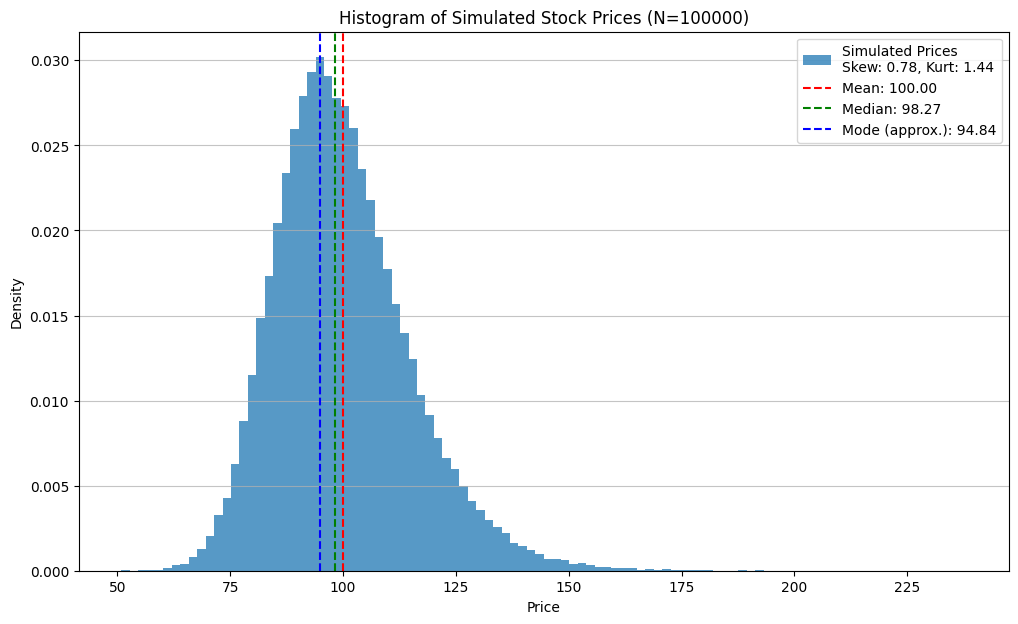


Successfully generated 100000 prices.
First 10 simulated prices: [90.90871830092459, 110.14589278666764, 105.59612350358938, 103.24512456504425, 117.16435906097165, 115.57930883564164, 109.7299217096595, 83.0285051815583, 116.23454218317298, 87.98405039045961]


In [ ]:
n = 100000  # Number of data points to generate

# Define target moments
tMean = 100.0      # e.g., average stock price
tSD = 15.0    # e.g., price volatility
tSkew = 0.8    # Positive skew (long tail to the right)
                        # For negative skew, e.g. -0.5
tKurtosis = 1.5 # Leptokurtic (fatter tails than normal)
                            # Normal distribution has 0 excess kurtosis
                            # Platykurtic (thinner tails) would be negative, e.g. -0.5

# Note on Kurtosis:
# This code assumes 'target_kurtosis_excess' is Fisher's excess kurtosis.
# Pearson's kurtosis = Excess Kurtosis + 3.
# If you have Pearson's kurtosis, subtract 3 to get the excess kurtosis.
# The Johnson SU distribution requires: excess_kurtosis > skewness^2 - 2.
# Example: If skewness = 0.8, then kurtosis must be > (0.8^2 - 2) = (0.64 - 2) = -1.36.
# Our target_kurtosis_excess = 1.5, which is > -1.36, so it should be achievable.

print(f"Simulating {n} stock prices with specified moments...")
simulated_prices_list, final_moments = simulate_stock_prices_with_moments(
    n_prices=n,
    target_mean=tMean,
    target_std_dev=tSD,
    target_skewness=TARGET_SKEWNESS,
    target_kurtosis_excess=TARGET_KURTOSIS_EXCESS
)

if simulated_prices_list:
    print(f"\nSuccessfully generated {len(simulated_prices_list)} prices.")
    print("First 10 simulated prices:", simulated_prices_list[:10])  # <--- ลบ # ออกแล้ว
else:
    print("Failed to generate stock prices.")

In [28]:
def simulate_stock_prices_with_moments(n_prices, target_mean, target_std_dev, target_skewness, target_kurtosis_excess, max_variation=0.30):
    """
    Simulates n_prices stock prices. Initially aims for specified overall moments,
    then applies a sequential constraint on maximum price variation.

    Args:
        n_prices (int): Number of stock prices to simulate.
        target_mean (float): The desired mean for the initial unconstrained generation.
        target_std_dev (float): The desired std dev for the initial unconstrained generation.
        target_skewness (float): The desired skewness for the initial unconstrained generation.
        target_kurtosis_excess (float): The desired excess kurtosis for the initial unconstrained generation.
        max_variation (float): The maximum allowable percentage change (e.g., 0.30 for +/- 30%).

    Returns:
        tuple: (list of constrained simulated prices, dict of actual moments of the constrained series)
               or (None, None) if params not found.
    """
    a_jsu, b_jsu = _find_johnsonsu_params(target_skewness, target_kurtosis_excess)

    if a_jsu is None or b_jsu is None or b_jsu <= 0:
        print("Could not determine valid Johnson SU parameters for initial generation. Aborting simulation.")
        return None, None

    # 1. Generate initial base prices aiming for target moments
    initial_variates = johnsonsu.rvs(a_jsu, b_jsu, loc=0, scale=1, size=n_prices, random_state=None)

    if n_prices <= 1:
        if n_prices == 1:
            base_simulated_prices = np.array([target_mean])
        else: # n_prices == 0
             base_simulated_prices = np.array([])
    else:
        mean_initial = np.mean(initial_variates)
        std_initial = np.std(initial_variates)
        if std_initial < 1e-9:
            standardized_variates = np.zeros_like(initial_variates)
        else:
            standardized_variates = (initial_variates - mean_initial) / std_initial
        base_simulated_prices = target_mean + standardized_variates * target_std_dev

    # 2. Apply sequential +/- max_variation constraint
    constrained_simulated_prices = np.zeros_like(base_simulated_prices)
    if n_prices > 0:
        constrained_simulated_prices[0] = base_simulated_prices[0] # Start with the first price from base generation
        for i in range(1, n_prices):
            previous_price = constrained_simulated_prices[i-1]
            candidate_price = base_simulated_prices[i]

            if previous_price == 0:
                 lower_bound = candidate_price
                 upper_bound = candidate_price
            else:
                lower_bound = previous_price * (1 - max_variation)
                upper_bound = previous_price * (1 + max_variation)

            constrained_simulated_prices[i] = np.clip(candidate_price, lower_bound, upper_bound)

    final_simulated_prices_array = constrained_simulated_prices

    # 3. Calculate actual moments of the FINAL CONSTRAINED simulated prices
    if n_prices > 0:
        actual_mean = np.mean(final_simulated_prices_array)
        actual_median = np.median(final_simulated_prices_array)
        if n_prices > 1:
            actual_std = np.std(final_simulated_prices_array)
            actual_skew = skew(final_simulated_prices_array)
            actual_kurtosis = scipy_kurtosis(final_simulated_prices_array, fisher=True)
        else:
            actual_std = 0
            actual_skew = 0
            actual_kurtosis = -3
    else:
        actual_mean, actual_std, actual_skew, actual_kurtosis, actual_median = (np.nan,) * 5

    actual_moments = {
        "mean": actual_mean,
        "std_dev": actual_std,
        "skewness": actual_skew,
        "kurtosis_excess": actual_kurtosis,
        "median": actual_median
    }

    print("\n--- Moments Targeted for Initial Unconstrained Generation ---")
    print(f"Mean: {target_mean:.4f}")
    print(f"Std Dev: {target_std_dev:.4f}")
    print(f"Skewness: {target_skewness:.4f}")
    print(f"Excess Kurtosis: {target_kurtosis_excess:.4f}")

    print("\n--- Actual Moments of Final CONSTRAINED Simulated Data (N={}) ---".format(n_prices))
    print(f"Mean: {actual_mean:.4f}")
    print(f"Std Dev: {actual_std:.4f}")
    print(f"Skewness: {actual_skew:.4f}")
    print(f"Excess Kurtosis: {actual_kurtosis:.4f}")
    print(f"Median: {actual_median:.4f}")

    if n_prices > 0:
        plt.figure(figsize=(12, 7))
        num_bins = min(100, int(np.sqrt(n_prices))) if n_prices > 1 else 1
        counts, bin_edges, patches = plt.hist(final_simulated_prices_array, bins=num_bins, density=True, alpha=0.75, label=f'Constrained Prices\nActual Skew: {actual_skew:.2f}\nActual Kurt: {actual_kurtosis:.2f}')

        if n_prices > 1:
            mode_bin_index = np.argmax(counts)
            approx_mode = (bin_edges[mode_bin_index] + bin_edges[mode_bin_index+1]) / 2
            actual_moments["mode_approx"] = approx_mode
            print(f"Mode (approx. from hist): {approx_mode:.4f}")
            plt.axvline(approx_mode, color='blue', linestyle='dashed', linewidth=1.5, label=f'Mode (approx.): {approx_mode:.2f}')

        plt.axvline(actual_mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Actual Mean: {actual_mean:.2f}')
        plt.axvline(actual_median, color='green', linestyle='dashed', linewidth=1.5, label=f'Actual Median: {actual_median:.2f}')

        plt.title(f'Histogram of CONSTRAINED Simulated Stock Prices (N={n_prices}, Max Var={max_variation*100:.0f}%)')
        plt.xlabel('Price')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(axis='y', alpha=0.75)
        plt.show()
    else:
        print("No prices generated to plot histogram.")

    return final_simulated_prices_array.tolist(), actual_moments

Simulating 50000 stock prices with specified initial moments and max variation constraint...

--- Moments Targeted for Initial Unconstrained Generation ---
Mean: 100.0000
Std Dev: 20.0000
Skewness: -0.8000
Excess Kurtosis: 2.5000

--- Actual Moments of Final CONSTRAINED Simulated Data (N=50000) ---
Mean: 99.1104
Std Dev: 15.9303
Skewness: -0.1204
Excess Kurtosis: -0.1389
Median: 99.8524
Mode (approx. from hist): 104.2899


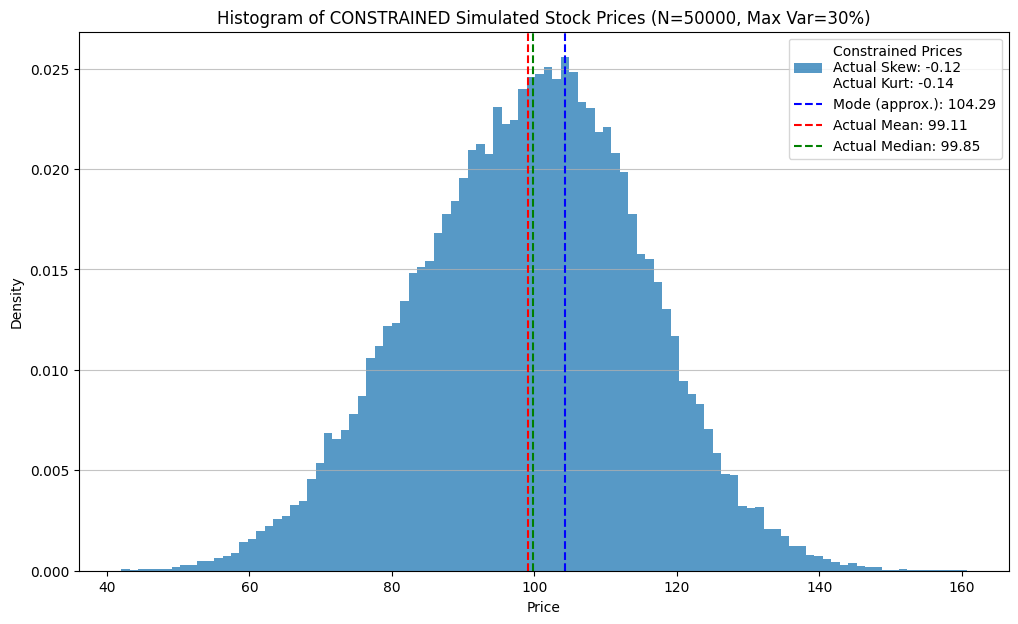


Successfully generated 50000 constrained prices.

First 10 constrained simulated prices:
[108.45493362167986, 97.42267418743485, 93.69223603572325, 95.72733202661573, 110.13623184936421, 77.09536229455495, 100.22397098292143, 101.36838571516267, 92.12407166733365, 92.98649034556004]


In [ ]:
# --- Example Usage (paste this in a separate cell or use it to replace the old example) ---
if __name__ == '__main__': # This block might not run automatically in Notebook unless it's the main script
    n = 50000
    MAX_PRICE_VARIATION = 0.30 # Max +/- 30% change from previous price

    tMean = 100.0
    tSD = 20.0
    TARGET_SKEWNESS = -0.8
    TARGET_KURTOSIS_EXCESS = 2.5

    print(f"Simulating {n} stock prices with specified initial moments and max variation constraint...")
    # Call the function (ensure this call happens in a cell you run)
    constrained_prices_list, final_actual_moments = simulate_stock_prices_with_moments(
        n_prices=n,
        target_mean=tMean,
        target_std_dev=tSD,
        target_skewness=TARGET_SKEWNESS,
        target_kurtosis_excess=TARGET_KURTOSIS_EXCESS,
        max_variation=MAX_PRICE_VARIATION
    )

    if constrained_prices_list:
        print(f"\nSuccessfully generated {len(constrained_prices_list)} constrained prices.")
        # --- Optional: Print part of the list ---
        print("\nFirst 10 constrained simulated prices:")
        print(constrained_prices_list[:10])
        # ----------------------------------------
    else:
        print("Failed to generate stock prices.")